In [233]:
# --- Étape 1 : Imports ---
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dropout, RepeatVector, TimeDistributed, Dense
import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [213]:
# --- Étape 2 : Chargement et prétraitement des données ---
file_path = r"C:\Users\dariu\Desktop\Anomaly-detection-in-Microservices-based-systems\service anomalies dataset\service_anomalies.csv" 
# file_path = r"C:\\Users\\dariu\\Desktop\\Anomaly-detection-in-Microservices-based-systems\\application anomalies dataset\\data1.csv"
df = pd.read_csv(file_path)
df['Time'] = pd.to_datetime(df['Time'], format='mixed', errors='coerce')
df.set_index('Time', inplace=True)
features = ['99th quantile', '50th quantile', 'Mean', '2xx', '4xx/5xx']
target = 'IsError'

X = df[features].values
y = df[target].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [214]:
# --- Étape 3 : Création des séquences temporelles ---
def create_sequences(X, y, time_steps=20):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

time_steps = 20
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

In [ ]:
# Définition explicite de la couche d'entrée
inputs = Input(shape=(X_seq.shape[1], X_seq.shape[2]))

# Encodeur LSTM
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
encoded = Dropout(0.2)(encoded)

# Répétition pour la reconstruction temporelle
repeat = RepeatVector(X_seq.shape[1])(encoded)

# Décodeur LSTM
decoded = LSTM(32, activation='relu', return_sequences=True)(repeat)

# Reconstruction finale des données d'entrée
outputs = TimeDistributed(Dense(X_seq.shape[2]))(decoded)

# Création du modèle complet (autoencodeur)
autoencoder = Model(inputs=inputs, outputs=outputs)

# Compilation et entraînement du modèle
optimize = keras.optimizers.Adagrad(learning_rate=0.0001, epsilon=1e-07)

loss = keras.losses.BinaryCrossentropy()

autoencoder.compile(optimizer=optimize, loss=loss)
autoencoder.fit(X_seq, X_seq, epochs=10, batch_size=32, validation_split=0.01)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.2225 - val_loss: 0.2007
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1153 - val_loss: 0.1881
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0520 - val_loss: 0.1811
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0117 - val_loss: 0.1763
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9912 - val_loss: 0.1731
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9563 - val_loss: 0.1702
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9518 - val_loss: 0.1662
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9233 - val_loss: 0.1645
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9476 - val_loss: 0.1630
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9008 - val_loss: 0.1625


In [245]:
# Modèle pour extraire les caractéristiques latentes depuis la couche encoded
feature_extractor = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)

# Prédiction des features latents
X_latent = feature_extractor.predict(X_seq)

print("Dimension des caractéristiques extraites :", X_latent.shape)


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Dimension des caractéristiques extraites : (2054, 64)


In [247]:
# --- Étape 6 : Entraînement de One-Class SVM sur les représentations LSTM ---
X_train, X_test, y_train, y_test = train_test_split(X_latent, y_seq, test_size=0.3, random_state=42)
X_train_ocsvm = X_train[y_train == 0]

ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.45) # nu = taux d’anomalies attendu
ocsvm.fit(X_train_ocsvm)

OneClassSVM(gamma='auto', nu=0.45)

🔖 Rapport de classification :

              precision    recall  f1-score   support

       False       0.74      0.59      0.66       325
        True       0.63      0.77      0.69       292

    accuracy                           0.68       617
   macro avg       0.69      0.68      0.68       617
weighted avg       0.69      0.68      0.68       617



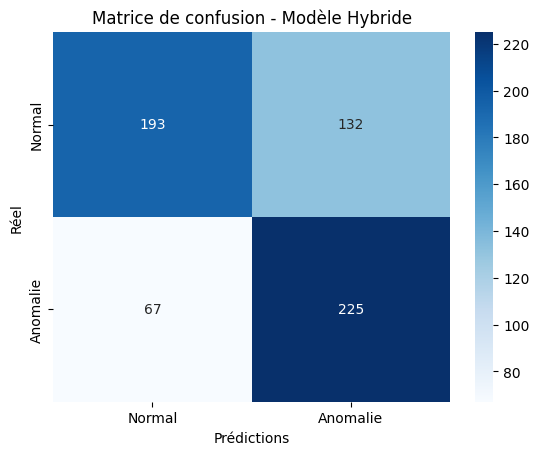

In [248]:
# --- Étape 7 : Prédiction et évaluation du modèle hybride ---
y_pred = ocsvm.predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0)

print("🔖 Rapport de classification :\n")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Anomalie'], yticklabels=['Normal','Anomalie'])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Modèle Hybride")
plt.show()

In [249]:
# Métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.68
Precision: 0.63
Recall: 0.77
F1-Score: 0.69


In [220]:
# --- Étape 8 : Analyse des erreurs de prédiction ---
fp = (y_pred == 1) & (y_test == 0)
fn = (y_pred == 0) & (y_test == 1)

print(f"Nombre de faux positifs : {fp.sum()}")
print(f"Nombre de faux négatifs : {fn.sum()}")

Nombre de faux positifs : 116
Nombre de faux négatifs : 45
